# Klasifikasi Penyakit Kulit berdasarkan feature extraction

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Processing Vascular lesion: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Training SVM
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Accuracy for SVM: 0.6243


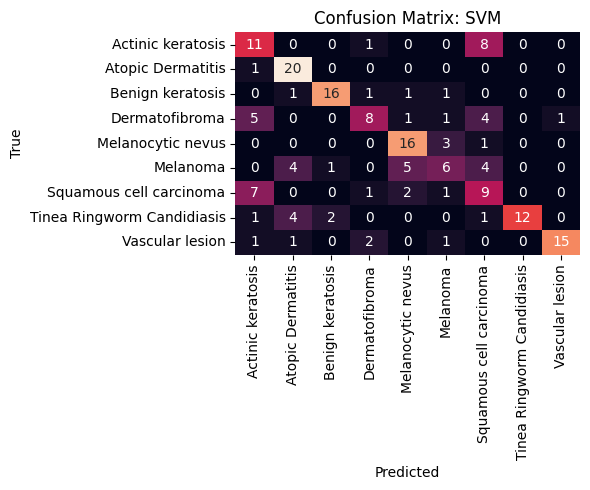

Training KNN
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Accuracy for KNN: 0.5912


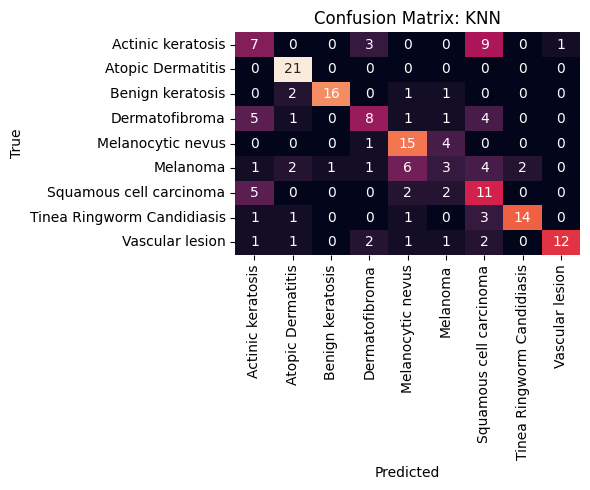

Training Decision Tree
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Accuracy for Decision Tree: 0.5635


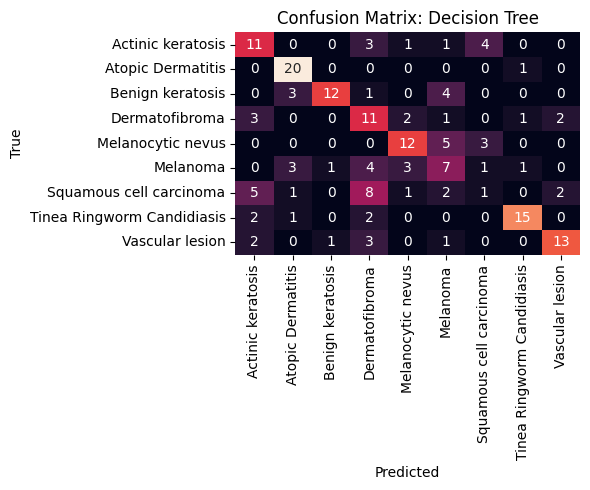


Results for SVM:
Accuracy: 0.6243093922651933
Classification Report:
                            precision    recall  f1-score   support

         Actinic keratosis       0.42      0.55      0.48        20
         Atopic Dermatitis       0.67      0.95      0.78        21
          Benign keratosis       0.84      0.80      0.82        20
            Dermatofibroma       0.62      0.40      0.48        20
         Melanocytic nevus       0.64      0.80      0.71        20
                  Melanoma       0.46      0.30      0.36        20
   Squamous cell carcinoma       0.33      0.45      0.38        20
Tinea Ringworm Candidiasis       1.00      0.60      0.75        20
           Vascular lesion       0.94      0.75      0.83        20

                  accuracy                           0.62       181
                 macro avg       0.66      0.62      0.62       181
              weighted avg       0.66      0.62      0.62       181


Results for KNN:
Accuracy: 0.5911602209944

In [ ]:
from IPython import get_ipython
from IPython.display import display
# %%
import os
import math
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.morphology import black_tophat, footprint_rectangle
from skimage.restoration import inpaint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from google.colab import drive
from skimage.filters import gaussian # Added import for gaussian filter
from scipy.stats import skew # Added import for skew

# 1. Mount Google Drive and Directories Setup
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/alternate PP"
RAW_TRAIN = os.path.join(BASE_DIR, "train")
RAW_VAL = os.path.join(BASE_DIR, "val")
PROC_ROOT = os.path.join(BASE_DIR, "processed2")
PROC_TRAIN = os.path.join(PROC_ROOT, "train")
PROC_VAL = os.path.join(PROC_ROOT, "val")

# Create directories for processed data
for split, raw_dir in [("train", RAW_TRAIN), ("val", RAW_VAL)]:
    out_dir = os.path.join(PROC_ROOT, split)
    # Check if raw_dir exists before listing its contents
    if os.path.exists(raw_dir):
        for cls in os.listdir(raw_dir):
            os.makedirs(os.path.join(out_dir, cls), exist_ok=True)
    else:
        print(f"Warning: Source directory not found: {raw_dir}")


def preprocess_image(image_path):
    # Load image and convert to RGB
    img = Image.open(image_path).convert('RGB')
    img = img.resize((512, 512), Image.Resampling.LANCZOS)  # Resizing to 512x512 for consistency
    arr = np.array(img, dtype=np.float32)  # Use float32 for less memory usage

    # Apply Black-Hat Transformation (Hair removal)
    # Ensure gray_img is scaled to 0-1 for skimage functions
    gray_img = rgb2gray(arr / 255.0) # Scale to 0-1
    black_hat_img = black_tophat(gray_img, footprint=footprint_rectangle((20, 20)))  # Hair removal

    # Create mask for inpainting
    mask = black_hat_img > 0.005  # Mask to identify areas for inpainting (use a small threshold)

    # Apply inpainting to the image using the 2D mask
    # The mask should be 2D (height, width) when channel_axis is specified
    inpainted_img = inpaint.inpaint_biharmonic(arr, mask, channel_axis=2)

    # Apply Gaussian filtering to smooth the inpainted image and reduce noise
    # Ensure inpainted_img is float before gaussian
    inpainted_img = gaussian(inpainted_img / 255.0, sigma=1, channel_axis=2) * 255.0


    # Return the processed image
    return np.clip(inpainted_img, 0, 255).astype(np.uint8)  # Ensure pixel values are in [0, 255]



# Process all train images
# Check if RAW_TRAIN directory exists
if os.path.exists(RAW_TRAIN):
    for cls in sorted(os.listdir(RAW_TRAIN)):
        src_paths = glob(os.path.join(RAW_TRAIN, cls, "*"))
        dst_dir = os.path.join(PROC_TRAIN, cls)
        # Check if dst_dir exists, if not create it (should be created by initial loop)
        os.makedirs(dst_dir, exist_ok=True)

        for p in tqdm(src_paths, desc=f"[TRAIN][{cls}]"):
            try:
                img = preprocess_image(p)
                fname = os.path.splitext(os.path.basename(p))[0]
                # The output of preprocess_image is already uint8, so no need to multiply by 255
                img_to_save = Image.fromarray(img)
                img_to_save.save(os.path.join(dst_dir, f"{fname}_preprocessed.png"))
            except Exception as e:
                print(f"Error processing image {p}: {e}")
else:
    print(f"Warning: Training source directory not found: {RAW_TRAAIN}")


# Process validation images similarly
# Check if RAW_VAL directory exists
if os.path.exists(RAW_VAL):
    for cls in sorted(os.listdir(RAW_VAL)):
        src_paths = glob(os.path.join(RAW_VAL, cls, "*"))
        dst_dir = os.path.join(PROC_VAL, cls)
        # Check if dst_dir exists, if not create it
        os.makedirs(dst_dir, exist_ok=True)

        for p in tqdm(src_paths, desc=f"[VAL][{cls}]"):
            try:
                img = preprocess_image(p)
                fname = os.path.splitext(os.path.basename(p))[0]
                # The output of preprocess_image is already uint8
                img_to_save = Image.fromarray(img)
                img_to_save.save(os.path.join(dst_dir, f"{fname}_preprocessed.png"))
            except Exception as e:
                print(f"Error processing image {p}: {e}")
else:
     print(f"Warning: Validation source directory not found: {RAW_VAL}")


# 3. Feature Extraction (GLCM and Statistical Features)
# Define color, texture, and LBP feature column names
color_cols = [f"{stat}_{c}" for c in ['R', 'G', 'B'] for stat in ('mean', 'std', 'skew')]
texture_cols = ["contrast", "correlation", "dissimilarity", "energy", "entropy", "homogeneity"]
lbp_cols = ["lbp_mean", "lbp_std"]

# Combine all the column names
cols = ["class"] + color_cols + texture_cols + lbp_cols

def extract_features(image_path):
    # Use the preprocessed images from PROC_ROOT
    img = Image.open(image_path).convert('RGB').resize((512, 512), Image.Resampling.LANCZOS)
    arr = np.array(img) # This array is already uint8 from preprocessing

    # Color Features - scale back to 0-1 for calculations if necessary, or keep as 0-255.
    # Calculations like mean/std are fine with 0-255. Skew needs float.
    r, g, b = arr[:,:,0].astype(np.float32), arr[:,:,1].astype(np.float32), arr[:,:,2].astype(np.float32)

    color_feats = [
        np.mean(r), np.std(r), skew(r.flatten()),
        np.mean(g), np.std(g), skew(g.flatten()),
        np.mean(b), np.std(b), skew(b.flatten())
    ]

    # GLCM Features
    # gray = (rgb2gray(arr)*255).astype(np.uint8) # arr is already 0-255 uint8
    gray = rgb2gray(arr).astype(np.uint8) # Convert RGB (0-255) to grayscale (0-255)
    glcm = graycomatrix(gray, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
    texture_feats = [
        graycoprops(glcm, 'contrast').mean(),
        graycoprops(glcm, 'correlation').mean(),
        graycoprops(glcm, 'dissimilarity').mean(),
        graycoprops(glcm, 'energy').mean(),
        -np.sum(glcm * np.log2(glcm + 1e-10)),  # entropy
        graycoprops(glcm, 'homogeneity').mean()
    ]

    # LBP Features
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    lbp_feats = [np.mean(lbp), np.std(lbp)]

    return color_feats + texture_feats + lbp_feats


# Feature extraction for training and validation sets
train_records = []
# Check if PROC_TRAIN directory exists
if os.path.exists(PROC_TRAIN):
    for cls in sorted(os.listdir(PROC_TRAIN)):
        # Only process _preprocessed.png files
        for p in tqdm(glob(os.path.join(PROC_TRAIN, cls, "*_preprocessed.png")), desc=f"Processing {cls}"):
             try:
                feats = extract_features(p)
                train_records.append([cls] + feats)
             except Exception as e:
                print(f"Error extracting features from {p}: {e}")
else:
    print(f"Warning: Processed training directory not found: {PROC_TRAIN}")


val_records = []
# Check if PROC_VAL directory exists
if os.path.exists(PROC_VAL):
    for cls in sorted(os.listdir(PROC_VAL)):
        # Only process _preprocessed.png files
        for p in tqdm(glob(os.path.join(PROC_VAL, cls, "*_preprocessed.png")), desc=f"Processing {cls}"):
            try:
                feats = extract_features(p)
                val_records.append([cls] + feats)
            except Exception as e:
                print(f"Error extracting features from {p}: {e}")
else:
    print(f"Warning: Processed validation directory not found: {PROC_VAL}")


# Convert to DataFrame
df_train = pd.DataFrame(train_records, columns=cols)
df_val = pd.DataFrame(val_records, columns=cols)

# Save to CSV
# Check if BASE_DIR exists before saving
if os.path.exists(BASE_DIR):
    df_train.to_csv(os.path.join(BASE_DIR, "train_features.csv"), index=False)
    df_val.to_csv(os.path.join(BASE_DIR, "val_features.csv"), index=False)
else:
    print(f"Warning: Base directory not found: {BASE_DIR}. Cannot save feature files.")


# 4. Modeling (SVM, KNN, Decision Tree)
# Check if feature files exist before loading
train_features_path = os.path.join(BASE_DIR, "train_features.csv")
val_features_path = os.path.join(BASE_DIR, "val_features.csv")

if os.path.exists(train_features_path) and os.path.exists(val_features_path):
    # Load DataFrames
    train_df = pd.read_csv(train_features_path)
    val_df = pd.read_csv(val_features_path)

    X_train, y_train = train_df.drop('class', axis=1).values, train_df['class'].values
    X_val, y_val = val_df.drop('class', axis=1).values, val_df['class'].values

    # Scaling Features
    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_val_s = scaler.transform(X_val)

    # Label Encoding
    le = LabelEncoder().fit(y_train)
    y_train_e = le.transform(y_train)
    y_val_e = le.transform(y_val)

    # Model Definitions
    models = {
        'SVM': SVC(),
        'KNN': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier()
    }

    # Hyperparameter tuning with GridSearchCV
    param_grids = {
        'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
        'KNN': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
        'Decision Tree': {'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}
    }

    # Grid Search for optimal hyperparameters
    results = {}
    for name, model in models.items():
        print(f"Training {name}")
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', verbose=1)
        grid_search.fit(X_train_s, y_train_e)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_val_s)
        accuracy = accuracy_score(y_val_e, y_pred)
        print(f"Accuracy for {name}: {accuracy:.4f}")

        # Store results
        results[name] = {
            'model': best_model,
            'accuracy': accuracy,
            'classification_report': classification_report(y_val_e, y_pred, target_names=le.classes_)
        }

        # Confusion Matrix
        cm = confusion_matrix(y_val_e, y_pred)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cbar=False)
        plt.title(f"Confusion Matrix: {name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()


    # 5. Evaluation
    # Print evaluation results for each model
    for name, result in results.items():
        print(f"\nResults for {name}:")
        print(f"Accuracy: {result['accuracy']}")
        print("Classification Report:")
        print(result['classification_report'])

else:
    print("Warning: Feature files not found. Skipping modeling and evaluation.")
    print(f"Expected files: {train_features_path}, {val_features_path}")

## import library

In [ ]:
from IPython import get_ipython
from IPython.display import display
import os
import math
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.morphology import black_tophat, footprint_rectangle
from skimage.restoration import inpaint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from google.colab import drive
from skimage.filters import gaussian
from scipy.stats import skew
from sklearn.linear_model import LogisticRegression

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/alternate PP"

Mounted at /content/drive


## Mount Google Drive and Setup Directories

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/alternate PP"
RAW_TRAIN = os.path.join(BASE_DIR, "train")
RAW_VAL = os.path.join(BASE_DIR, "val")
PROC_ROOT = os.path.join(BASE_DIR, "processed2")
PROC_TRAIN = os.path.join(PROC_ROOT, "train")
PROC_VAL = os.path.join(PROC_ROOT, "val")

# Create directories for processed data
for split, raw_dir in [("train", RAW_TRAIN), ("val", RAW_VAL)]:
    out_dir = os.path.join(PROC_ROOT, split)
    if os.path.exists(raw_dir):
        for cls in os.listdir(raw_dir):
            os.makedirs(os.path.join(out_dir, cls), exist_ok=True)
    else:
        print(f"Warning: Source directory not found: {raw_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocessing Image Function

In [ ]:
def preprocess_image(image_path):
    # Load image and convert to RGB
    img = Image.open(image_path).convert('RGB')
    img = img.resize((512, 512), Image.Resampling.LANCZOS)  # Resizing to 512x512 for consistency
    arr = np.array(img, dtype=np.float32)  # Use float32 for less memory usage

    # Apply Black-Hat Transformation (Hair removal)
    gray_img = rgb2gray(arr / 255.0)  # Scale to 0-1
    black_hat_img = black_tophat(gray_img, footprint=footprint_rectangle((20, 20)))  # Hair removal

    # Create mask for inpainting
    mask = black_hat_img > 0.005  # Mask to identify areas for inpainting

    # Apply inpainting to the image using the 2D mask
    inpainted_img = inpaint.inpaint_biharmonic(arr, mask, channel_axis=2)

    # Apply Gaussian filtering to smooth the inpainted image and reduce noise
    inpainted_img = gaussian(inpainted_img / 255.0, sigma=1, channel_axis=2) * 255.0

    # Return the processed image
    return np.clip(inpainted_img, 0, 255).astype(np.uint8)  # Ensure pixel values are in [0, 255]


## Process Training Images

In [ ]:
# Process all train images
if os.path.exists(RAW_TRAIN):
    for cls in sorted(os.listdir(RAW_TRAIN)):
        src_paths = glob(os.path.join(RAW_TRAIN, cls, "*"))
        dst_dir = os.path.join(PROC_TRAIN, cls)
        os.makedirs(dst_dir, exist_ok=True)

        for p in tqdm(src_paths, desc=f"[TRAIN][{cls}]"):
            try:
                img = preprocess_image(p)
                fname = os.path.splitext(os.path.basename(p))[0]
                img_to_save = Image.fromarray(img)
                img_to_save.save(os.path.join(dst_dir, f"{fname}_preprocessed.png"))
            except Exception as e:
                print(f"Error processing image {p}: {e}")
else:
    print(f"Warning: Training source directory not found: {RAW_TRAIN}")

## Process Validation Images

In [ ]:
# Process validation images
if os.path.exists(RAW_VAL):
    for cls in sorted(os.listdir(RAW_VAL)):
        src_paths = glob(os.path.join(RAW_VAL, cls, "*"))
        dst_dir = os.path.join(PROC_VAL, cls)
        os.makedirs(dst_dir, exist_ok=True)

        for p in tqdm(src_paths, desc=f"[VAL][{cls}]"):
            try:
                img = preprocess_image(p)
                fname = os.path.splitext(os.path.basename(p))[0]
                img_to_save = Image.fromarray(img)
                img_to_save.save(os.path.join(dst_dir, f"{fname}_preprocessed.png"))
            except Exception as e:
                print(f"Error processing image {p}: {e}")
else:
    print(f"Warning: Validation source directory not found: {RAW_VAL}")

## Feature Extraction Function

In [ ]:
def extract_features(image_path):
    img = Image.open(image_path).convert('RGB').resize((512, 512), Image.Resampling.LANCZOS)
    arr = np.array(img)  # This array is already uint8 from preprocessing

    r, g, b = arr[:,:,0].astype(np.float32), arr[:,:,1].astype(np.float32), arr[:,:,2].astype(np.float32)

    color_feats = [
        np.mean(r), np.std(r), skew(r.flatten()),
        np.mean(g), np.std(g), skew(g.flatten()),
        np.mean(b), np.std(b), skew(b.flatten())
    ]

    gray = rgb2gray(arr).astype(np.uint8)
    glcm = graycomatrix(gray, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
    texture_feats = [
        graycoprops(glcm, 'contrast').mean(),
        graycoprops(glcm, 'correlation').mean(),
        graycoprops(glcm, 'dissimilarity').mean(),
        graycoprops(glcm, 'energy').mean(),
        -np.sum(glcm * np.log2(glcm + 1e-10)),  # entropy
        graycoprops(glcm, 'homogeneity').mean()
    ]

    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    lbp_feats = [np.mean(lbp), np.std(lbp)]

    return color_feats + texture_feats + lbp_feats

## Extract Features for Training and Validation Sets

In [ ]:
train_records = []
if os.path.exists(PROC_TRAIN):
    for cls in sorted(os.listdir(PROC_TRAIN)):
        for p in tqdm(glob(os.path.join(PROC_TRAIN, cls, "*_preprocessed.png")), desc=f"Processing {cls}"):
            try:
                feats = extract_features(p)
                train_records.append([cls] + feats)
            except Exception as e:
                print(f"Error extracting features from {p}: {e}")
else:
    print(f"Warning: Processed training directory not found: {PROC_TRAIN}")

val_records = []
if os.path.exists(PROC_VAL):
    for cls in sorted(os.listdir(PROC_VAL)):
        for p in tqdm(glob(os.path.join(PROC_VAL, cls, "*_preprocessed.png")), desc=f"Processing {cls}"):
            try:
                feats = extract_features(p)
                val_records.append([cls] + feats)
            except Exception as e:
                print(f"Error extracting features from {p}: {e}")
else:
    print(f"Warning: Processed validation directory not found: {PROC_VAL}")

## Save Feature Data to CSV

In [ ]:
df_train = pd.DataFrame(train_records, columns=cols)
df_val = pd.DataFrame(val_records, columns=cols)

# Save to CSV
if os.path.exists(BASE_DIR):
    df_train.to_csv(os.path.join(BASE_DIR, "train_features.csv"), index=False)
    df_val.to_csv(os.path.join(BASE_DIR, "val_features.csv"), index=False)
else:
    print(f"Warning: Base directory not found: {BASE_DIR}. Cannot save feature files.")

## Modeling (SVM, KNN, Decision Tree)

Training Logistic Regression
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy for Logistic Regression: 0.5249


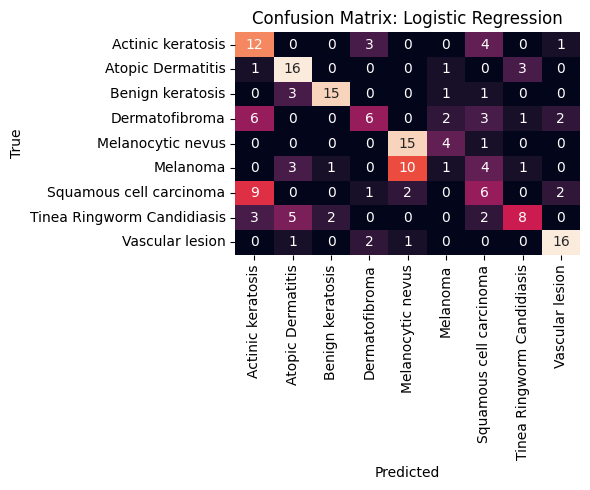

Training SVM
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Accuracy for SVM: 0.6243


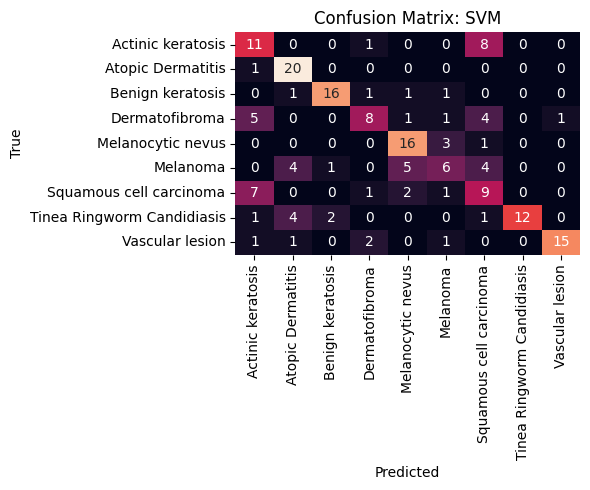

Training KNN
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Accuracy for KNN: 0.5912


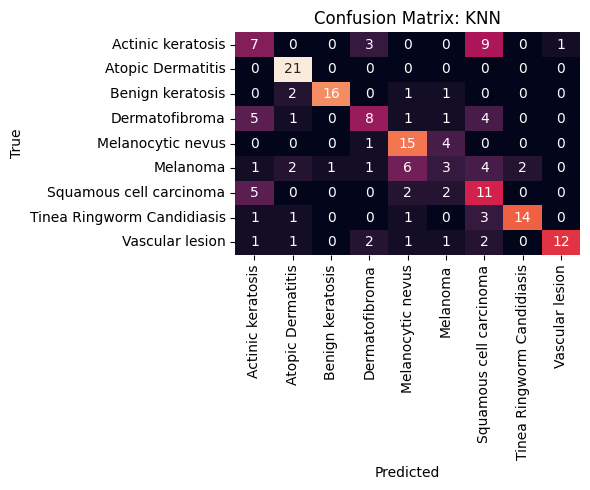

Training Decision Tree
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Accuracy for Decision Tree: 0.5746


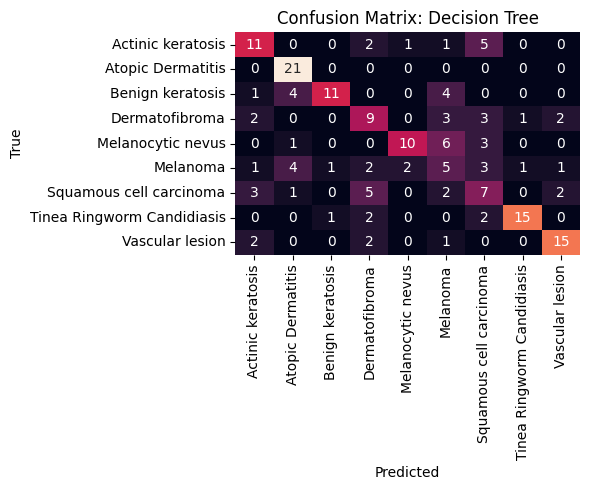

In [ ]:
train_features_path = os.path.join(BASE_DIR, "train_features.csv")
val_features_path = os.path.join(BASE_DIR, "val_features.csv")

if os.path.exists(train_features_path) and os.path.exists(val_features_path):
    # Load DataFrames
    train_df = pd.read_csv(train_features_path)
    val_df = pd.read_csv(val_features_path)

    X_train, y_train = train_df.drop('class', axis=1).values, train_df['class'].values
    X_val, y_val = val_df.drop('class', axis=1).values, val_df['class'].values

    # Scaling Features
    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_val_s = scaler.transform(X_val)

    # Label Encoding
    le = LabelEncoder().fit(y_train)
    y_train_e = le.transform(y_train)
    y_val_e = le.transform(y_val)

    # Model Definitions (Including Logistic Regression)
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),  # Added Logistic Regression
        'SVM': SVC(),
        'KNN': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier()
    }

    # Hyperparameter tuning with GridSearchCV
    param_grids = {
        'Logistic Regression': {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']},  # Hyperparameters for Logistic Regression
        'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
        'KNN': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
        'Decision Tree': {'max_depth': [10, 20, None], 'min_samples_split': [2, 5]}
    }

    results = {}
    for name, model in models.items():
        print(f"Training {name}")
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', verbose=1)
        grid_search.fit(X_train_s, y_train_e)

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_val_s)
        accuracy = accuracy_score(y_val_e, y_pred)
        print(f"Accuracy for {name}: {accuracy:.4f}")

        results[name] = {
            'model': best_model,
            'accuracy': accuracy,
            'classification_report': classification_report(y_val_e, y_pred, target_names=le.classes_)
        }

        # Confusion Matrix
        cm = confusion_matrix(y_val_e, y_pred)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cbar=False)
        plt.title(f"Confusion Matrix: {name}")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()
else:
    print("Warning: Feature files not found. Skipping modeling and evaluation.")
    print(f"Expected files: {train_features_path}, {val_features_path}")

## Evaluation

In [ ]:
for name, result in results.items():
    print(f"\nResults for {name}:")
    print(f"Accuracy: {result['accuracy']}")
    print("Classification Report:")
    print(result['classification_report'])


Results for Logistic Regression:
Accuracy: 0.5248618784530387
Classification Report:
                            precision    recall  f1-score   support

         Actinic keratosis       0.39      0.60      0.47        20
         Atopic Dermatitis       0.57      0.76      0.65        21
          Benign keratosis       0.83      0.75      0.79        20
            Dermatofibroma       0.50      0.30      0.38        20
         Melanocytic nevus       0.54      0.75      0.62        20
                  Melanoma       0.11      0.05      0.07        20
   Squamous cell carcinoma       0.29      0.30      0.29        20
Tinea Ringworm Candidiasis       0.62      0.40      0.48        20
           Vascular lesion       0.76      0.80      0.78        20

                  accuracy                           0.52       181
                 macro avg       0.51      0.52      0.50       181
              weighted avg       0.51      0.52      0.51       181


Results for SVM:
Accuracy:

## Visualisasi after PreProcessing

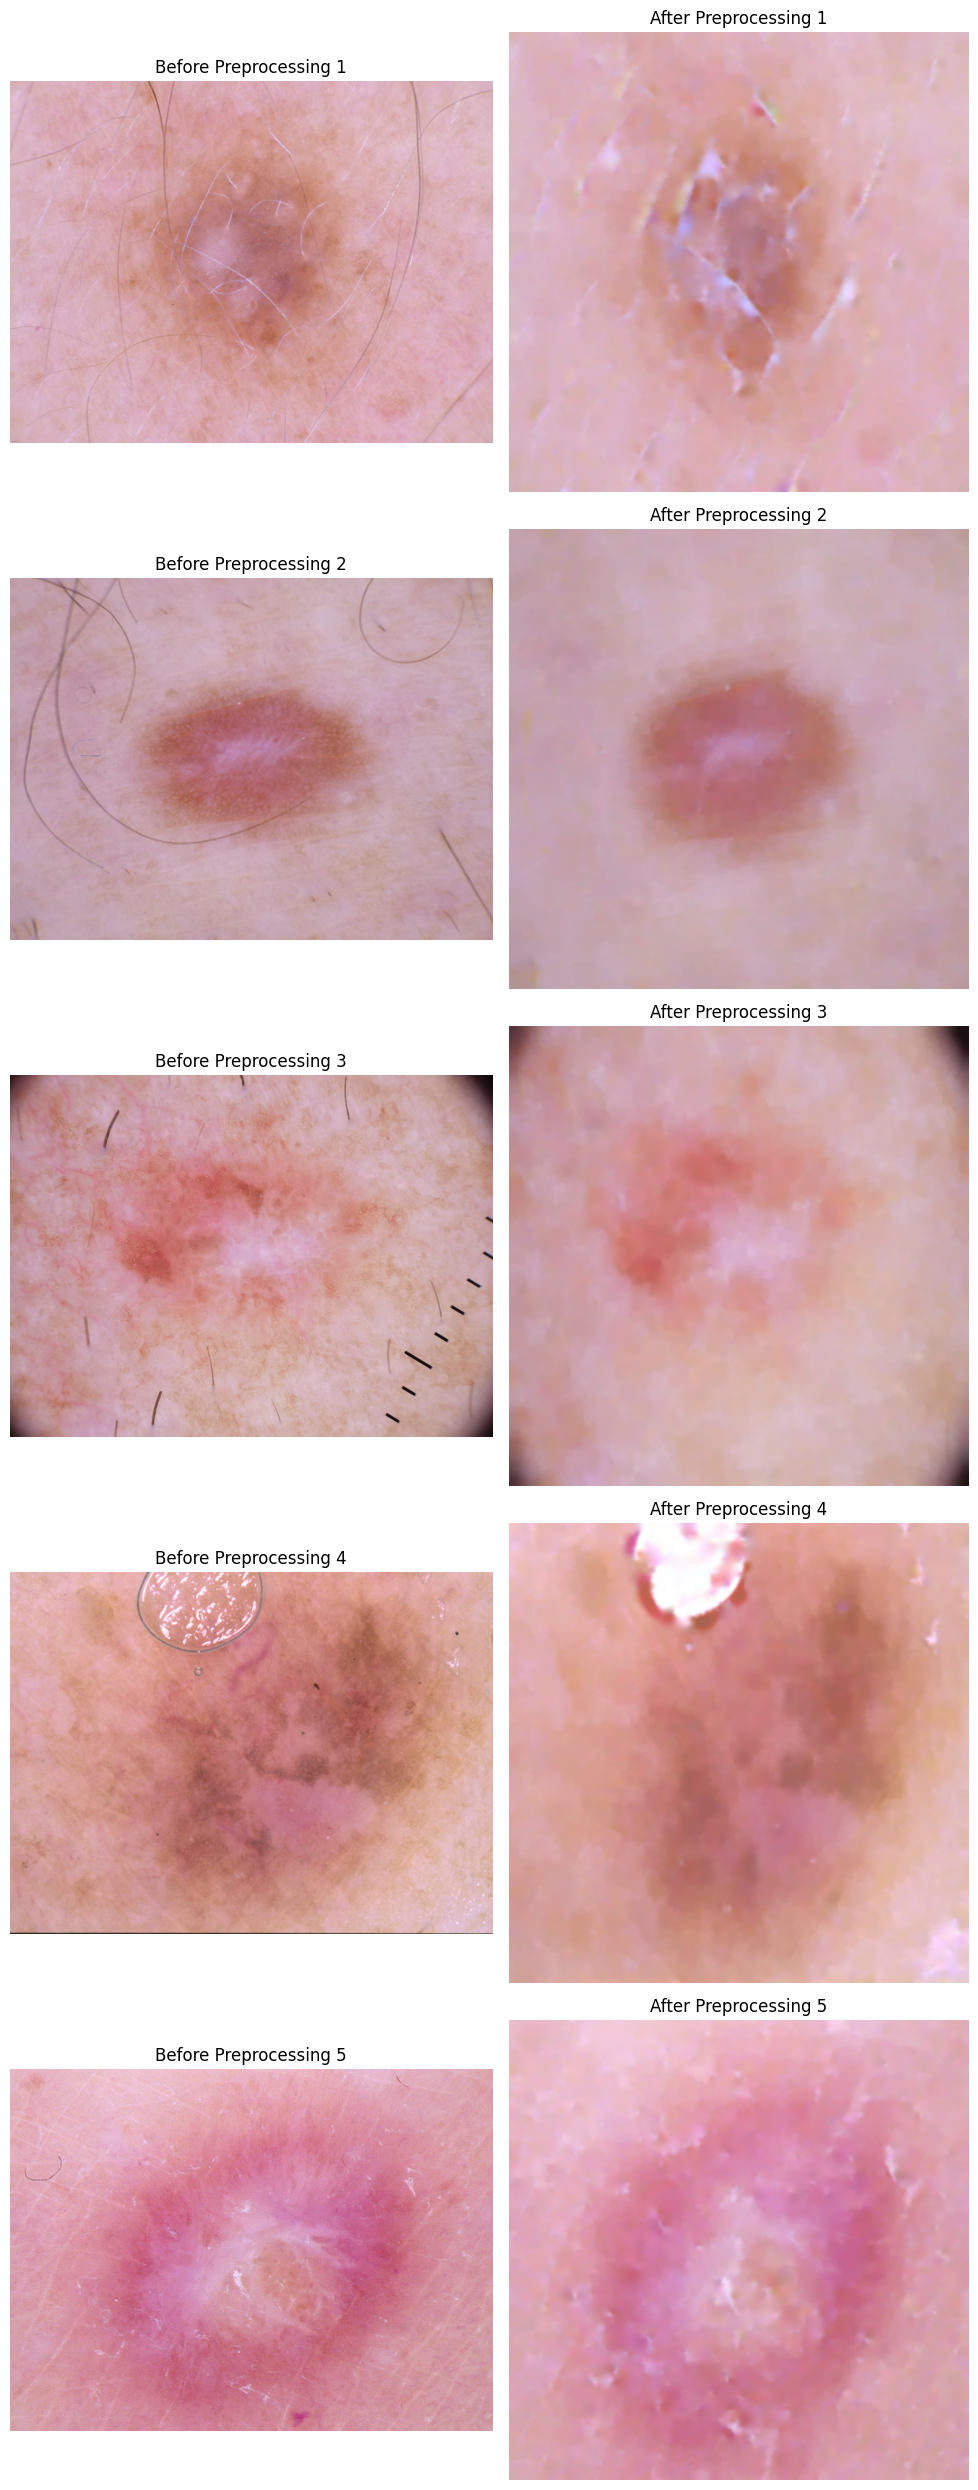

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

def display_multiple_image_comparison(before_paths, after_paths):
    """
    Menampilkan perbandingan antara gambar sebelum dan setelah preprocessing
    untuk banyak gambar.
    """
    num_images = len(before_paths)

    # Menyusun figure dengan subplots, satu gambar per kolom
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

    # Iterasi untuk setiap gambar
    for i in range(num_images):
        img_before = Image.open(before_paths[i])
        img_after = Image.open(after_paths[i])

        # Menampilkan gambar sebelum preprocessing
        axes[i, 0].imshow(img_before)
        axes[i, 0].set_title(f'Before Preprocessing {i + 1}')
        axes[i, 0].axis('off')

        # Menampilkan gambar setelah preprocessing
        axes[i, 1].imshow(img_after)
        axes[i, 1].set_title(f'After Preprocessing {i + 1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Contoh penggunaan: Menampilkan beberapa gambar pertama dari folder "train" sebelum dan setelah preprocessing
train_cls = sorted(os.listdir(RAW_TRAIN))[3]  # Mengambil kelas pertama
before_paths = [os.path.join(RAW_TRAIN, train_cls, f) for f in os.listdir(os.path.join(RAW_TRAIN, train_cls))[:5]]  # 5 Gambar pertama
after_paths = [os.path.join(PROC_TRAIN, train_cls, f) for f in os.listdir(os.path.join(PROC_TRAIN, train_cls))[:5]]  # 5 Gambar pertama setelah preprocessing

display_multiple_image_comparison(before_paths, after_paths)



In [ ]:
train_df.head()

,class,mean_R,std_R,skew_R,mean_G,std_G,skew_G,mean_B,std_B,skew_B,contrast,correlation,dissimilarity,energy,entropy,homogeneity,lbp_mean,lbp_std
0,Actinic keratosis,225.43880,20.145262,-1.831720,176.77700,21.218830,-0.967782,177.01562,24.525627,-0.735287,0.0,1.0,0.0,1.0,-5.770781e-10,1.0,8.0,0.0
1,Actinic keratosis,196.95174,4.702259,-0.570550,147.09412,11.218348,-0.572450,166.12430,11.619388,-1.181102,0.0,1.0,0.0,1.0,-5.770781e-10,1.0,8.0,0.0
2,Actinic keratosis,227.25827,3.572470,-0.959381,143.59473,13.889803,-0.411852,153.32086,12.053554,-0.827393,0.0,1.0,0.0,1.0,-5.770781e-10,1.0,8.0,0.0
3,Actinic keratosis,216.27533,9.634522,-1.649041,164.26016,20.428339,-1.484163,167.77928,22.283278,-1.551814,0.0,1.0,0.0,1.0,-5.770781e-10,1.0,8.0,0.0
4,Actinic keratosis,167.79141,13.873354,-0.806670,134.09238,17.658827,-0.654522,149.35043,19.037964,-0.488850,0.0,1.0,0.0,1.0,-5.770781e-10,1.0,8.0,0.0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   class          697 non-null    object 
 1   mean_R         697 non-null    float64
 2   std_R          697 non-null    float64
 3   skew_R         697 non-null    float64
 4   mean_G         697 non-null    float64
 5   std_G          697 non-null    float64
 6   skew_G         697 non-null    float64
 7   mean_B         697 non-null    float64
 8   std_B          697 non-null    float64
 9   skew_B         697 non-null    float64
 10  contrast       697 non-null    float64
 11  correlation    697 non-null    float64
 12  dissimilarity  697 non-null    float64
 13  energy         697 non-null    float64
 14  entropy        697 non-null    float64
 15  homogeneity    697 non-null    float64
 16  lbp_mean       697 non-null    float64
 17  lbp_std        697 non-null    float64
dtypes: float64

In [ ]:
val_df.head()

,class,mean_R,std_R,skew_R,mean_G,std_G,skew_G,mean_B,std_B,skew_B,contrast,correlation,dissimilarity,energy,entropy,homogeneity,lbp_mean,lbp_std
0,Actinic keratosis,225.75380,10.122472,-0.315215,165.51512,19.061195,0.039253,180.15320,22.651613,-0.089976,0.0,1.0,0.0,1.0,-5.770781e-10,1.0,8.0,0.0
1,Actinic keratosis,202.79773,7.298779,-1.640151,164.23413,15.210075,-0.317817,173.07442,20.301174,-0.733313,0.0,1.0,0.0,1.0,-5.770781e-10,1.0,8.0,0.0
2,Actinic keratosis,203.21916,17.238132,-0.749597,169.36163,22.123375,-0.195336,182.14545,25.502975,-0.287926,0.0,1.0,0.0,1.0,-5.770781e-10,1.0,8.0,0.0
3,Actinic keratosis,224.62502,4.277358,-0.448004,173.80374,13.601994,-0.602345,189.20721,16.282614,-1.370074,0.0,1.0,0.0,1.0,-5.770781e-10,1.0,8.0,0.0
4,Actinic keratosis,193.24190,12.691578,-0.552895,160.80011,20.402000,-0.335978,164.90834,23.260443,-0.129667,0.0,1.0,0.0,1.0,-5.770781e-10,1.0,8.0,0.0


In [ ]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   class          181 non-null    object 
 1   mean_R         181 non-null    float64
 2   std_R          181 non-null    float64
 3   skew_R         181 non-null    float64
 4   mean_G         181 non-null    float64
 5   std_G          181 non-null    float64
 6   skew_G         181 non-null    float64
 7   mean_B         181 non-null    float64
 8   std_B          181 non-null    float64
 9   skew_B         181 non-null    float64
 10  contrast       181 non-null    float64
 11  correlation    181 non-null    float64
 12  dissimilarity  181 non-null    float64
 13  energy         181 non-null    float64
 14  entropy        181 non-null    float64
 15  homogeneity    181 non-null    float64
 16  lbp_mean       181 non-null    float64
 17  lbp_std        181 non-null    float64
dtypes: float64

## Visualisasi Distribusi Kolom

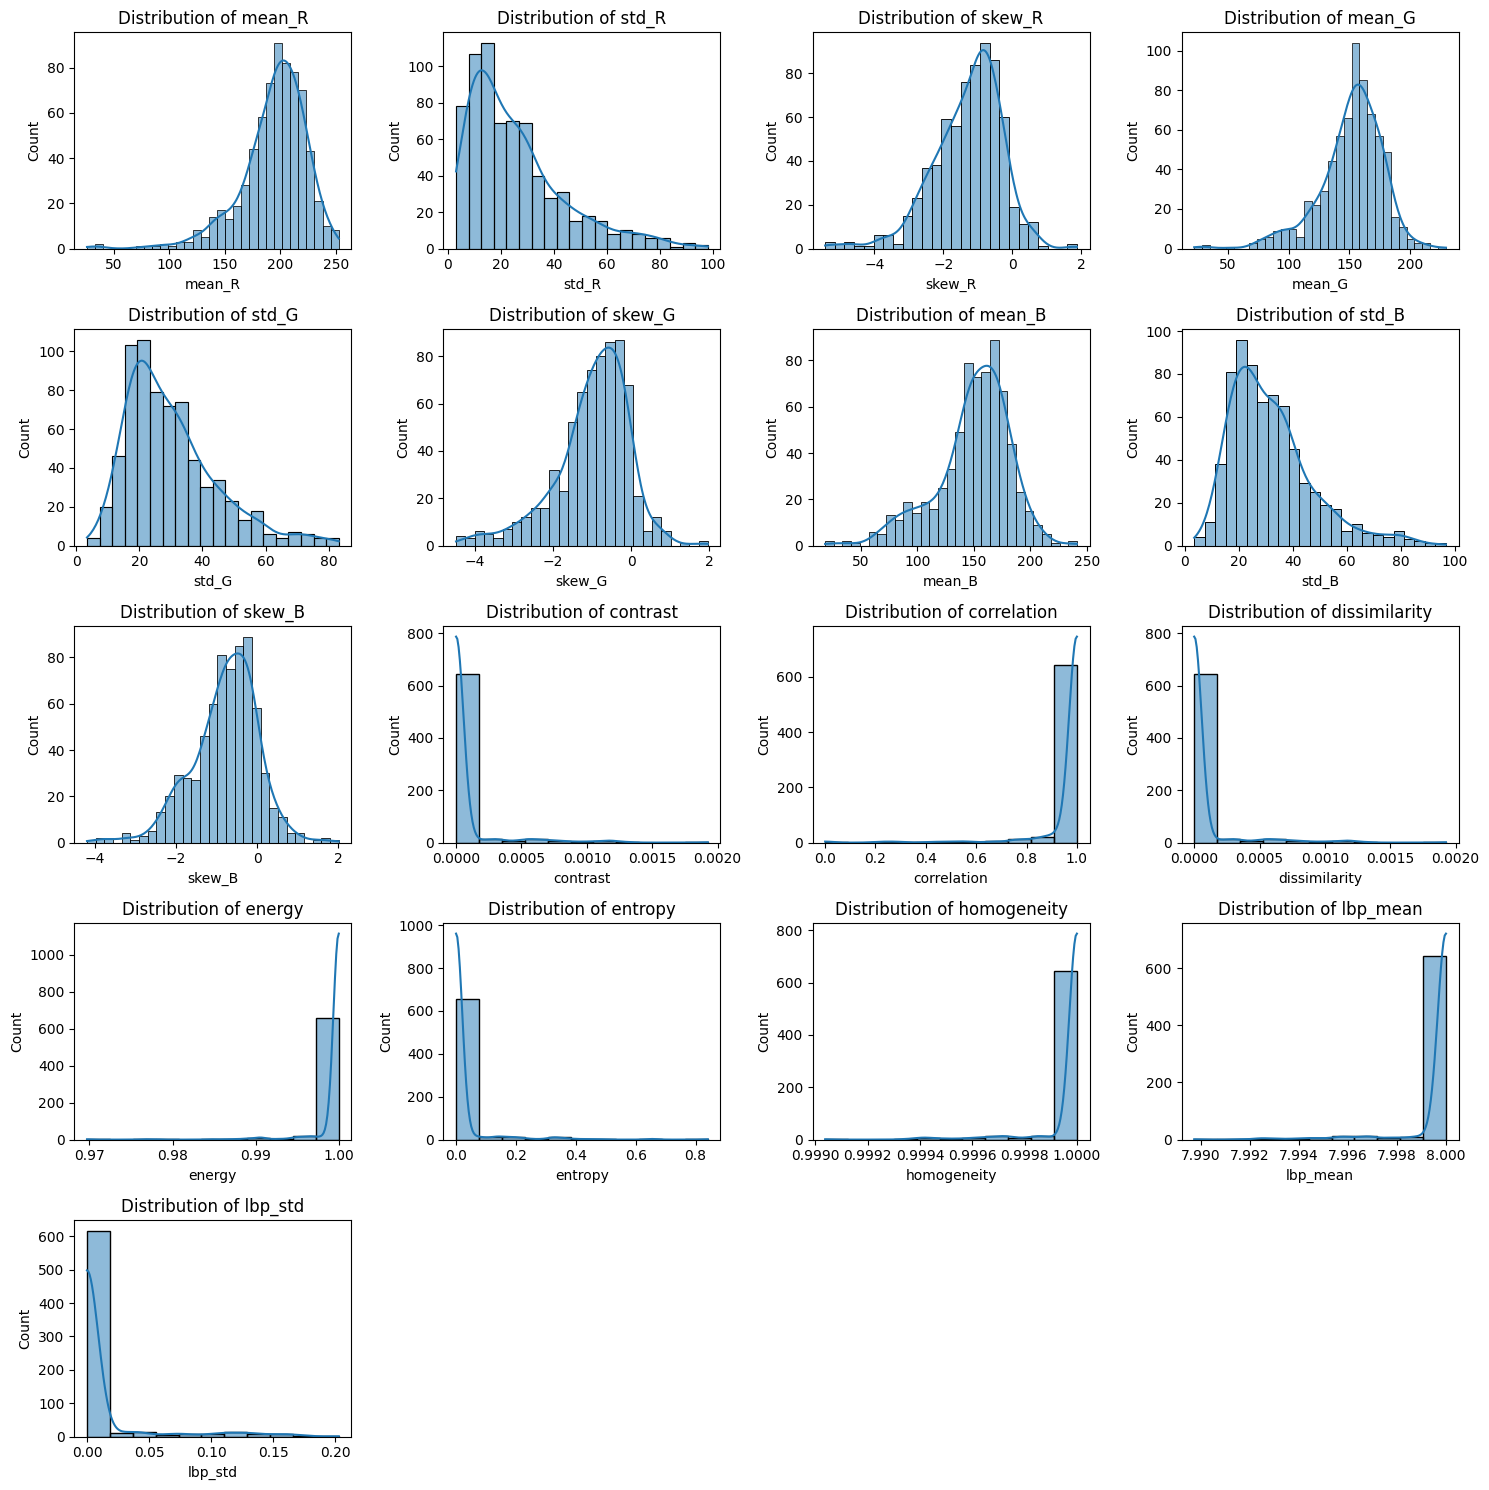

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os # Added import for os if not already imported

# Memuat dataset
# Assuming BASE_DIR is defined elsewhere in your notebook
train_features_path = os.path.join(BASE_DIR, "train_features.csv")
train_df = pd.read_csv(train_features_path)

# Menyiapkan plot untuk setiap kolom dalam dataset
num_columns = train_df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the number of columns to plot (excluding 'class' if it's numerical, though it's not in this case)
# We should exclude 'class' from num_columns if it were mistakenly included
# Assuming 'class' is the only non-numeric column we want to exclude
feature_columns = [col for col in num_columns if col != 'class'] # Ensure 'class' is not plotted

# Calculate the required number of rows based on the number of features
n_features = len(feature_columns)
n_cols = 4  # Number of columns per row in the plot grid
n_rows = (n_features + n_cols - 1) // n_cols # Calculate rows needed, rounding up

plt.figure(figsize=(15, n_rows * 3)) # Adjust figure height based on number of rows

# Loop melalui setiap kolom untuk membuat histogram
for i, col in enumerate(feature_columns, 1): # Iterate through the feature columns
    plt.subplot(n_rows, n_cols, i)  # Mengatur layout grid dynamically
    sns.histplot(train_df[col], kde=True)  # Plot distribusi dengan KDE
    plt.title(f'Distribution of {col}')

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()